In [4]:
%load_ext autoreload
%autoreload 2


import pandas as pd 
import geopandas as gpd
from urllib.parse import urlparse, urlunparse, urlencode
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from tenacity import retry, wait_fixed
from pathlib import Path

dd = Path().cwd().parent.parent / 'data'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from time import sleep

def get_csv_url(spreadsheet_url):
    # Parse the URL into components

    parsed_url = urlparse(spreadsheet_url)

    if '/edit' not in spreadsheet_url:
        raise ValueError("The provided URL does not contain '/edit'")
    new_path =  parsed_url.path .replace('/edit', '/export')
    
    # Create the query string for exporting as CSV
    query = urlencode({'format': 'csv', 'gid': parsed_url.query.split('=')[1]})
    
    # Reassemble the URL with the new path and query
    csv_url = urlunparse((parsed_url.scheme, parsed_url.netloc, new_path, '', query, ''))
    
    return csv_url

def get_df():

    sa = 'https://docs.google.com/spreadsheets/d/17xsA-l8WVXhOQ4pvzUyD6pbPwHRfpfCoLFDumD-bNcA/edit?gid=1582713929'
    csv_url = get_csv_url(sa)
    print(csv_url)
    df = pd.read_csv(csv_url)
    return df

# Initialize the geocoder
geolocator = Nominatim(user_agent="geoapi")

# Function to geocode an address

def geocode_address(address):
    
    if not address:
        print(f"    No address: {address}")
        return None
    
    try:
        location = geolocator.geocode(address)
        if location:
            print(f"    complete: {address}: {location}")
            return  Point(location.longitude, location.latitude)
            
    except Exception as e:
        print(f"    Error for : {address}: {e}")    
        return None
    
def geocode_df(df):

    if 'geometry' not in df.columns:
        df['geometry'] = None

    # Apply geocoding to the Address column
    for idx, row in df.iterrows():
        
        print(f"Geocoding {idx}: {row.Address}")
        
        if row.geometry is not None:
            print(f"    exists: {row.Address}")
            continue
        
        df.loc[idx, 'geometry'] = geocode_address(row.Address)
        sleep(2)

    return gpd.GeoDataFrame(df, geometry='geometry').set_crs(epsg=4326)



In [6]:
gjf = dd / 'competitors.json'

if not gjf.exists():
    df = get_df()
    gdf = geocode_df(df)
    gdf.to_file(gjf, driver='GeoJSON')
else:
    gdf = gpd.read_file(gjf)
    # Check if the geometry is valid
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom if geom.is_valid else None)
    # Drop rows with invalid geometries
    gdf = gdf.dropna(subset=['geometry'])
    # Reproject to EPSG:4326
    gdf = gdf.set_crs(epsg=4326)
    # Save the cleaned GeoDataFrame back to GeoJSONa
    gdf.to_file(gjf, driver='GeoJSON')
    


In [ ]:
# Calculate the median speed in North Clunty. 
from shapely import wkt

rsdf = pd.read_csv(dd/"sandag_road_speed.csv")
rsdf['geometry'] = rsdf['geometry'].apply(wkt.loads)
rsdf = gpd.GeoDataFrame(rsdf, geometry='geometry')
rsdf = rsdf[rsdf.geometry.centroid.y > 32.6740634]

rsdf['Speed 2022 MPH'].describe()
median_speed = rsdf['Speed 2022 MPH'].median()
median_speed_kmh = median_speed * 1.60934
median_speed_kmh

In [10]:
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon

# Function to compute isochrones

def comp_one_node_points(name, lat, lon, travel_time, travel_speed):

    # Convert travel time to distance in meters
    travel_distance = (travel_time / 60) * (travel_speed * 1000)

    # Get the graph for the area around the point
    G = ox.graph_from_point((lat, lon), dist=travel_distance, network_type='drive')
   
    # Find the nearest node to the point
    center_node = ox.distance.nearest_nodes(G, lon, lat)
    
    if len(G[center_node]) == 0:
        # This probably should not happen, but it does. Something about the node being in a non
        # connected subgraph, so fing the largest strongly connected subgraph, and get the nearest node in that.
        largest_scc = max(nx.strongly_connected_components(G), key=len)
        G_sub = G.subgraph(largest_scc)
        center_node = ox.distance.nearest_nodes(G_sub, lon, lat)
    
    print("    Center node:", center_node)

    # Compute subgraph for the isochrone
    subgraph = nx.ego_graph(G, center_node, radius=travel_distance, distance='length')

    # Get the isochrone polygon
    nodes = list(subgraph.nodes)
    print("    Number of nodes in subgraph:", len(nodes))
    node_points = [Point((G.nodes[node]['x'], G.nodes[node]['y'])) for node in nodes]
    
    return node_points
    

def comp_one_isochrone(name, lat, lon, travel_time=30, travel_speed=50): # 50km/h
    
    node_points = comp_one_node_points(name, lat, lon, travel_time=travel_time, travel_speed=travel_speed)
    try:
        polygon = Polygon([[p.x, p.y] for p in node_points]).convex_hull

        return polygon
    except Exception as e:
        print(f"Error creating polygon for index {name}: {e}")
        return None

def compute_isochrones(gdf, travel_time=30, travel_speed=50): # 50km/h
    """
    Compute isochrones for each point in the GeoDataFrame.

    Parameters:
    - gdf: GeoDataFrame containing points.
    - travel_time: Travel time in minutes.
    - travel_speed: Travel speed in km/h 

    Returns:
    - A GeoDataFrame with isochrones as polygons.
    """
    isochrones = []

    for idx, row in gdf.iterrows():
        # Get the point's coordinates
        print(row.Company)
        point = row.geometry
        lat, lon = point.y, point.x
        
        iso = comp_one_isochrone(row.Company, lat, lon, travel_time=travel_time, travel_speed=travel_speed)
        if iso:
            isochrones.append(iso)
        else:
            isochrones.append(None)

       
    # Add isochrones to the GeoDataFrame
    gdf['isochrone'] = isochrones
    return gdf

r = gdf.iloc[4]
lat, lon = r.geometry.y, r.geometry.x
np = comp_one_node_points('test', lat, lon, travel_time=15, travel_speed=20)
len(np)

    Center node: 49220103
    Number of nodes in subgraph: 1647


1647

The Coder School


    Center node: 1778815452
    Number of nodes in subgraph: 6508
The Coder School
    Center node: 384250317
    Number of nodes in subgraph: 4865
The Coder School
    Center node: 49733024
    Number of nodes in subgraph: 3293
Code Ninjas
    Center node: 384246704
    Number of nodes in subgraph: 5256
Code Ninjas
    Center node: 49220103
    Number of nodes in subgraph: 5110
Code Ninjas
    Center node: 49748386
    Number of nodes in subgraph: 4809
Code Ninjas
    Center node: 48985119
    Number of nodes in subgraph: 4954
Ember Coding
    Center node: 1778821503
    Number of nodes in subgraph: 6454
The League
    Center node: 1774175439
    Number of nodes in subgraph: 3407


<Axes: >

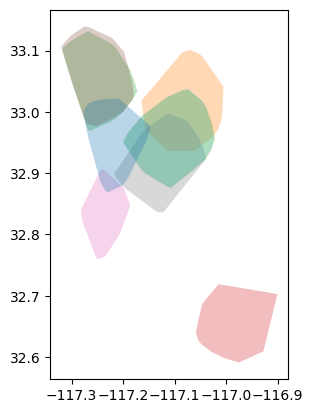

In [11]:

# Compute isochrones for the points in gdf
gidf = compute_isochrones(gdf, travel_time=20, travel_speed=median_speed_kmh*.75)

# Display the GeoDataFrame with isochrones
gidf.head()

idf = gidf[['Company', 'Address', 'isochrone']].copy()
idf = gpd.GeoDataFrame(idf, geometry='isochrone')
idf = idf.set_crs(epsg=4326)

idf.plot(column='Address', alpha=.3)


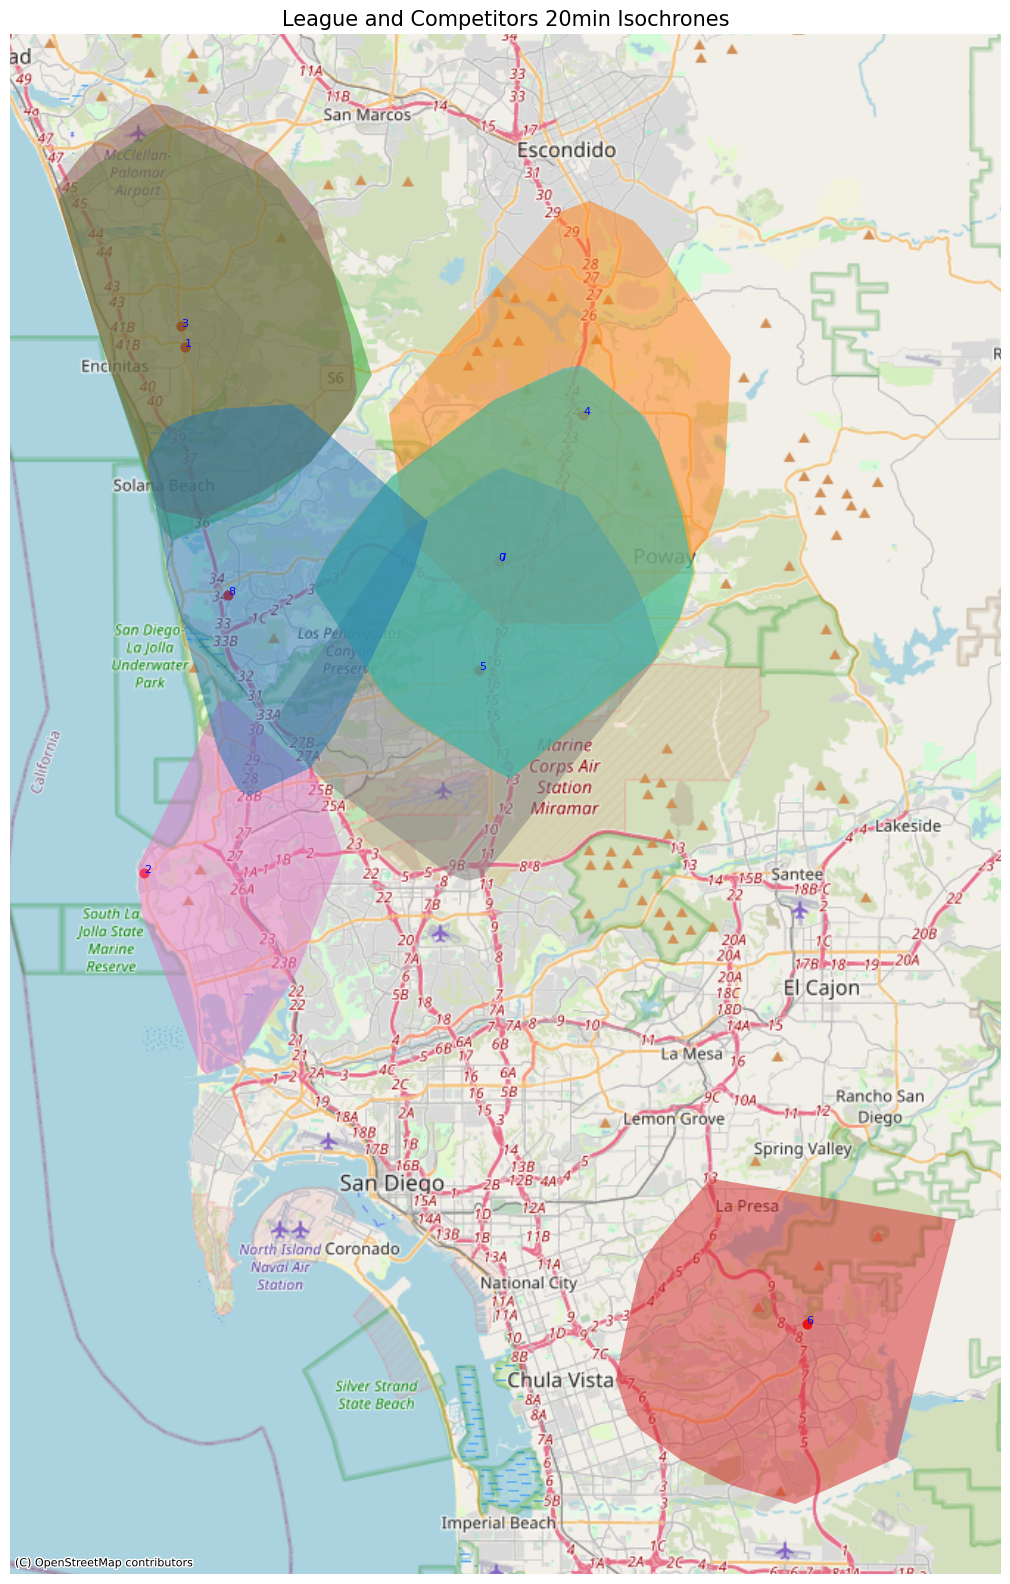

In [12]:
import contextily as ctx

import matplotlib.pyplot as plt

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(20, 20))

t = gdf.to_crs(epsg=3857)

t.plot(ax=ax, color='red', markersize=40)

for x, y, label in zip(t.geometry.x, t.geometry.y, t.index):
    ax.text(x, y, str(label), fontsize=8, color='blue')
    
    
idf.to_crs(epsg=3857).plot(column='Address', ax=ax, alpha=.5)
    
# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set plot title and labels
ax.set_title("League and Competitors 20min Isochrones", fontsize=15)
ax.set_axis_off()

plt.show()